In [ ]:
#pip install opencv-python
#pip install tensorflow
#pip install tensorflow_hub

In [36]:
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import json

In [139]:
def dancer_x_y(interpreter, image):
    KEYPOINT_REVERSE = {
        0: "nose",
        1: "left_eye",
        2: "right_eye",
        3: "left_ear",
        4: "right_ear",
        5: "left_shoulder",
        6: "right_shoulder",
        7: "left_elbow",
        8: "right_elbow",
        9: "left_wrist",
        10: "right_wrist",
        11: "left_hip",
        12: "right_hip",
        13: "left_knee",
        14: "right_knee",
        15: "left_ankle",
        16: "right_ankle"
    }
    
    result = [{"keypoints": []}]
    
    tmp = []
    input_size = 192
    
    y, x, _ = image.shape
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    
    #movenet 함수로 키포인트 추출
    keypoints = movenet(interpreter, input_image)
    cnt = 0
    total_score = 0
    for keypoint in keypoints[0, 0, :, :]:
        keypoint = keypoint.astype(float)
        total_score+=keypoint[2]

        yc = keypoint[0] * y
        xc = keypoint[1] * x

        data = {"y": yc,
                "x": xc,
                "score": keypoint[2],
                "name": KEYPOINT_REVERSE[cnt]}

        tmp.append(data)
        cnt += 1
    result[0]["keypoints"] = tmp
    result[0]["score"] = total_score / 17

    return result

In [140]:
def movenet(interpreter, input_image):
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

In [160]:
def video_to_xy(filepath, post_id):
    '''
    비디오의 프레임 단위로 각 부위별 x,y 좌표를 json 파일로 저장하는 함수입니다.

    filepath : 비디오가 있는 파일경로 : './exo-lmr_shorts_720.mp4'
    post_id : '게시글 아이디.json'으로 json 파일을 저장합니다.

    - 출력값 설명
    video_to_xy[0] : FPS
    video_to_xy[1] ~ ... : n번째 이미지의 keypoint 값
    '''
    
    #비디오 불러오기
    video = cv2.VideoCapture(filepath)
    
    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path="./lightning_int8.tflite")
    interpreter.allocate_tensors()

    if not video.isOpened():
        #비디오를 열 수 없다면 Could not Open 출력
        print("Could not Open :", filepath)
        exit(0)
    else:
        #불러온 비디오 파일의 정보 출력
        length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = video.get(cv2.CAP_PROP_FPS)

        print("length :", length)
        print("width :", width)
        print("height :", height)
        print("fps :", fps)
        
        result = [round(fps)]
        
        while(video.isOpened()):
            ret, image = video.read()
            if not ret:
                print('완료')
                break
            
            print('Saved coordinate :', video.get(1))
            result.append(dancer_x_y(interpreter, image))
            
        with open(post_id +".json", 'w') as file:
            json.dump(result, file, indent=4)

In [161]:
filepath = './spicy_karina.mp4'
video_to_xy(filepath,'karina')

length : 602
width : 720
height : 1280
fps : 30.0
Saved coordinate : 1.0
Saved coordinate : 2.0
Saved coordinate : 3.0
Saved coordinate : 4.0
Saved coordinate : 5.0
Saved coordinate : 6.0
Saved coordinate : 7.0
Saved coordinate : 8.0
Saved coordinate : 9.0
Saved coordinate : 10.0
Saved coordinate : 11.0
Saved coordinate : 12.0
Saved coordinate : 13.0
Saved coordinate : 14.0
Saved coordinate : 15.0
Saved coordinate : 16.0
Saved coordinate : 17.0
Saved coordinate : 18.0
Saved coordinate : 19.0
Saved coordinate : 20.0
Saved coordinate : 21.0
Saved coordinate : 22.0
Saved coordinate : 23.0
Saved coordinate : 24.0
Saved coordinate : 25.0
Saved coordinate : 26.0
Saved coordinate : 27.0
Saved coordinate : 28.0
Saved coordinate : 29.0
Saved coordinate : 30.0
Saved coordinate : 31.0
Saved coordinate : 32.0
Saved coordinate : 33.0
Saved coordinate : 34.0
Saved coordinate : 35.0
Saved coordinate : 36.0
Saved coordinate : 37.0
Saved coordinate : 38.0
Saved coordinate : 39.0
Saved coordinate : 40.0

In [144]:
with open(json_path, 'r') as file:
    data = json.load(file)

x=[]
y=[]
name=[]
for i in range(17):
    x.append(data[0]['keypoints'][i]['x'])
    y.append(data[0]['keypoints'][i]['y'])
    name.append(data[0]['keypoints'][i]['name'])

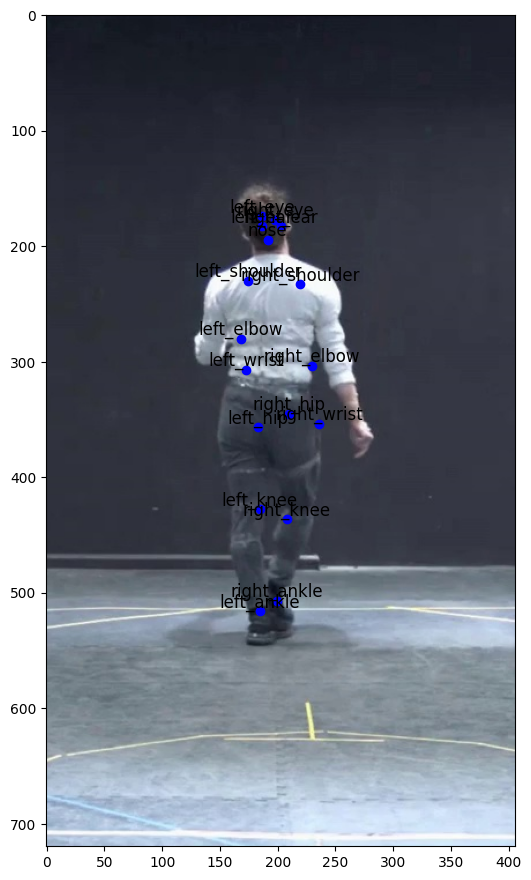

In [145]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image_on_graph(image_path):
    # 이미지 로드
    img = mpimg.imread(image_path)

    # 그래프 생성
    fig, ax = plt.subplots(figsize=(19.2, 10.8))

    # 이미지를 그래프에 나타내기
    ax.imshow(img)
    for i in range(17):
        ax.scatter(x[i], y[i], color='blue', marker='o')
        ax.text(x[i], y[i], name[i], fontsize=12, ha='center', va='bottom')

    # 그래프에 이미지 출력
    plt.show()

# 이미지를 그래프 위에 나타내기
display_image_on_graph(img_path)

In [66]:
yoga = './yoga.jpg'
yoga = tf.io.read_file(yoga)
yoga = tf.image.decode_jpeg(yoga)
json_yoga = dancer_x_y(movenet, yoga)


x=[]
y=[]
for i in range(17):
    x.append(json_yoga[0]['keypoints'][i]['x'])
    y.append(json_yoga[0]['keypoints'][i]['y'])

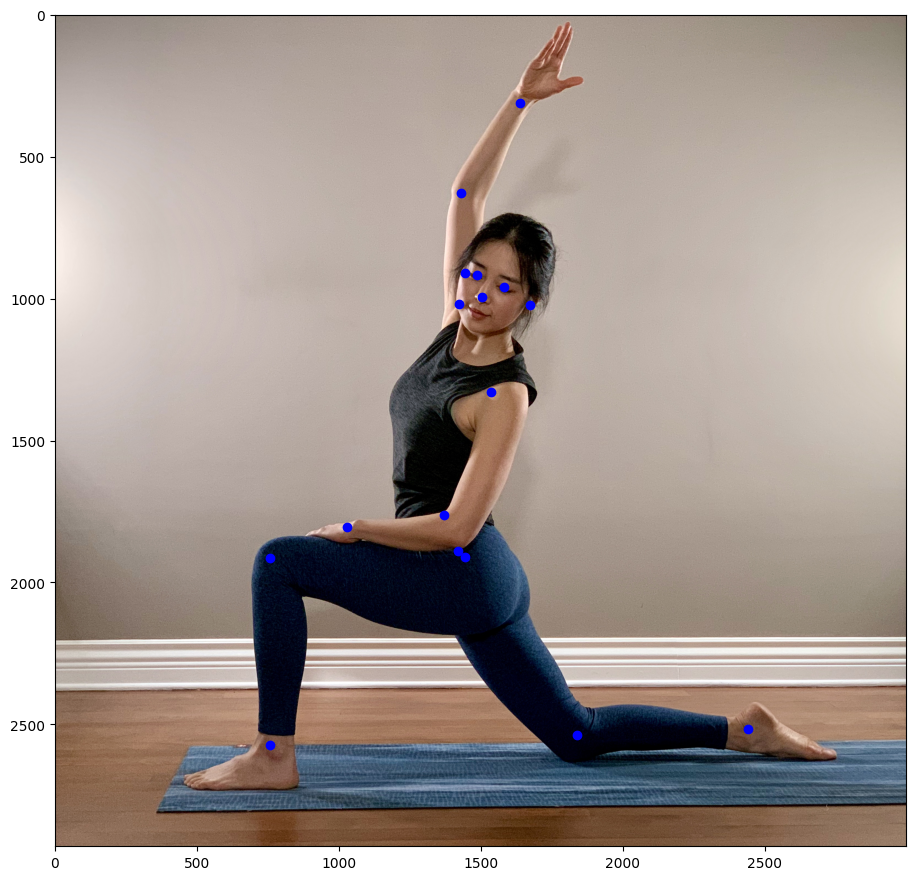

In [71]:
# 이미지를 그래프 위에 나타내기
display_image_on_graph('./yoga.jpg')